## Objective: Segmenting out worms from the OpenWorm Movement Database video(s) and extracting their skeleton form




In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import shutil
import random 
from skimage.morphology import skeletonize

plt.rcParams["figure.figsize"] = (10,10)

ROOT = "/content/drive/My Drive/"

### Moving the timelapse video(s) from google drive to the runtime

Have a look at [worm_tracking_pipeline.ipynb](https://nbviewer.jupyter.org/github/devoworm/GSoC-2020/blob/master/Pre-trained%20Models%20%28DevLearning%29/notebooks/worm_tracking_pipeline.ipynb) for an explanantion of the terminal commands seen below

In [0]:
# !tar -czf /content/drive/"My Drive"/work_data.tar.gz -C /content/drive/"My Drive"/work_data .
!cp /content/drive/"My Drive"/work_data.tar.gz /content/
!mkdir work_data
!tar -xvf  /content/work_data.tar.gz -C /content/work_data .
clear_output()

## Using a subclip of the timelapse for faster propotyping

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [0]:
source_path = "work_data/video/wild_type.mp4"
target_path = "work_data/trimmed/first_five_seconds.mp4"

trim_video(
    source_path = source_path, 
    start_time =15, 
    end_time =  40, 
    target_path = target_path)


[MoviePy] Running:
>>> /usr/bin/ffmpeg -y -i work_data/video/wild_type.mp4 -ss 15.00 -t 25.00 -vcodec copy -acodec copy work_data/trimmed/first_five_seconds.mp4
... command successful.


# Extracting frames from the videos
* `video_to_frames(video_path, new_folder_path)` converts all the frames of a specified video file and saves it into a folder as .jpg files 

In [0]:
def video_to_frames(video_path, new_folder_path):
    frames_paths = []
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path) 
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    return frames_paths

In [0]:
frames_folder = "work_data/trimmed/frames"
frames_paths = video_to_frames(
                                video_path = target_path,
                                new_folder_path = frames_folder
                               )

saved  735  frames at  work_data/trimmed/frames


## Some cv2 utilities

* `read_and_shrink_image(image_path, shrink_factor = 2)` reads the image in grayscale from the path and shrinks it by a factor of `shrink_factor**2`
* `draw_circle` and `draw_rectangle` draws circles and rectangles respectively

In [0]:
def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small


def draw_circle(image, vertex, radius, thickness = 5):
    with_circle = cv2.circle(
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (255, 255, 255),  ## (B, G, R) 
                            thickness = thickness)
    return with_circle


def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(255, 255, 255), thickness=3)
    return image


# Pipeline prototyping
* First we blur the image by a small amount using `cv2.blur(image, kernel_size)` in order to remove noise and grain. A larger kernel size leads to a larger blur factor
* `kernel_size = (x,y)` - `x` and `y` define the horizontal and the vertical sizes of the kernel. Higher the `x`, higher the horizontal blur. Same goes for `y`

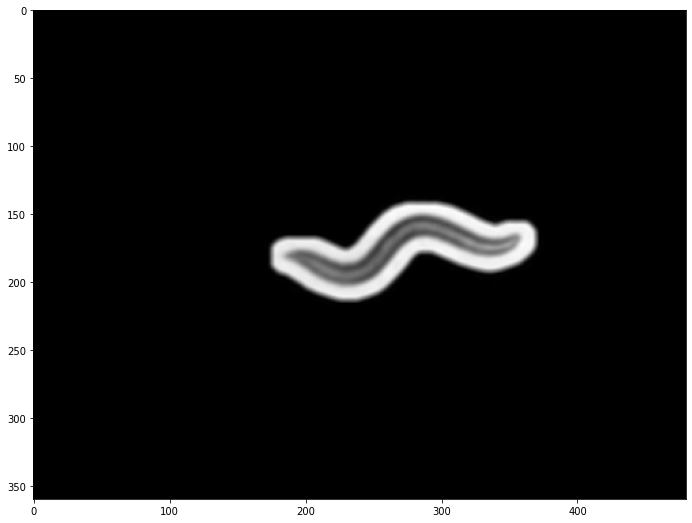

In [0]:
plt.rcParams["figure.figsize"] = (15,9)
sample_image = cv2.imread(frames_folder+ "/" + "100.jpg", 0)
sample_image = cv2.blur(sample_image, (5,5))
plt.imshow(sample_image, cmap = "gray")
plt.show()

## Visualising the stages of segmentation

#### Stage 1: extracting the gray background around the worm
> * `cv2.threshold(sample_image, lower_threshold , new_value ,cv2.THRESH_BINARY)` - it converts all the pixel values **above** the `lower_threshold` to the `new_value` which is 255 (white).
> * `cv2.THRESH_BINARY_INV` converts all the pixel values **below** the `lower_threshold` to the `new_value` which is 255 (white).
> * Here we use `cv2.THRESH_BINARY` to extract all the images where the gray value is greater than 72 and turn them to 255 (white)


#### Stage 2: removing the extracted bankground
> * `sample_image[thresh1_inv_final == 255] = 0` sets all the pixels which were set to 255 (in stage 1) to zero in the original image. `thresh1_inv_final` is an "inverted mask" used to eliminate the "light gray" area around the worm. 

#### Stage 3: removing any remaining noise 
> * We use `cv2.erode()` for this purpose with a kernel size of (4,4), any smaller and it doesn't fully remove the noisy "ring" around the worm (as seen on stage 2).

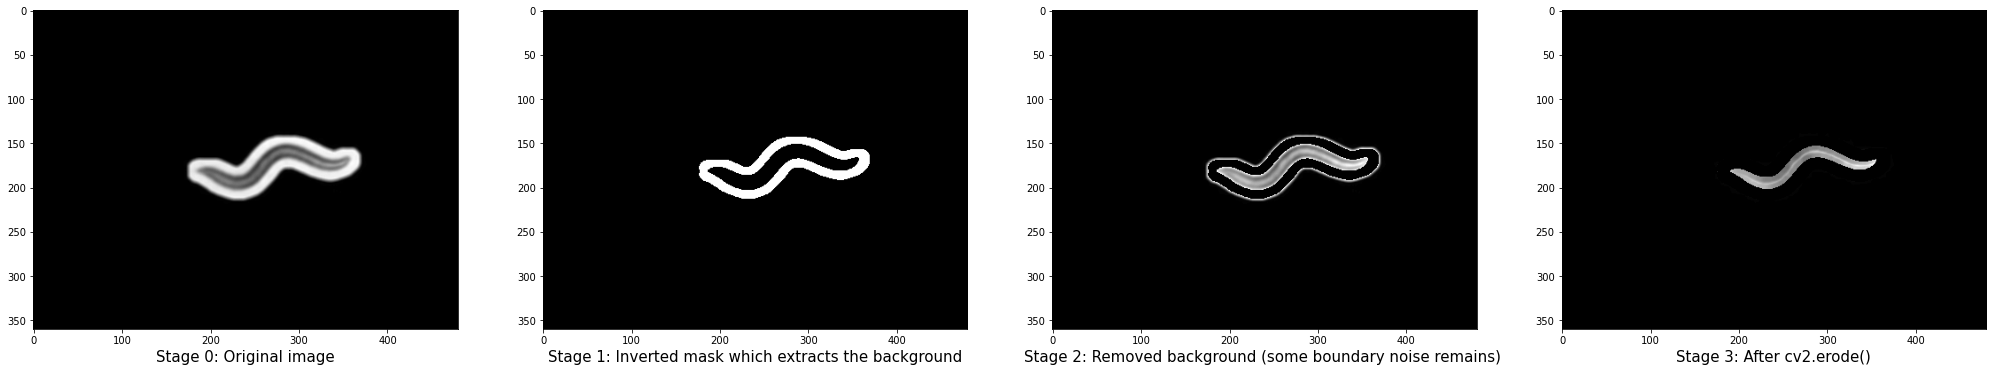

In [0]:
fig, ax = plt.subplots(1,4, figsize = (35,15))


sample_image = cv2.imread(frames_folder+ "/" + "100.jpg", 0)
sample_image = cv2.blur(sample_image, (5,5))

ax[0].imshow(sample_image, cmap = "gray")
ax[0].set_xlabel("Stage 0: Original image", fontsize= 15)
fig.show()

ret,thresh1_inv_final = cv2.threshold(sample_image,69, 255,cv2.THRESH_BINARY)

ax[1].imshow(thresh1_inv_final, cmap = "gray")
ax[1].set_xlabel("Stage 1: Inverted mask which extracts the background", fontsize= 15)
fig.show()
sample_image[thresh1_inv_final == 255] = 0

ax[2].imshow(sample_image, cmap = "gray")
ax[2].set_xlabel("Stage 2: Removed background (some boundary noise remains) ", fontsize= 15)
fig.show()

kernel = np.ones((4,4), np.uint8)

eroded_image = cv2.erode(sample_image, kernel)
ax[3].imshow(eroded_image, cmap = "gray")
ax[3].set_xlabel("Stage 3: After cv2.erode()", fontsize= 15)
fig.show()

### Stages 1, 2  and 3 can be shortened into the following function(s)
* `segment_worm()` moves the image to the HSV color space and extracts all the pixel values between lying between `lower_gray` and `upper_gray`. Which gives us `mask_gray`
* `cv2.bitwise_and()` was used between the original image and the mask


In [0]:
def segment_worm(image, lower_gray = [0, 0, 10], higher_gray = [0, 0, 90]):
    img = (image).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_gray = np.array(lower_gray, np.uint8)
    upper_gray = np.array(higher_gray, np.uint8)
    mask_gray = cv2.inRange(hsv, lower_gray, upper_gray)
    img_res = cv2.bitwise_and(img, img, mask = mask_gray)
    img_color  = cv2.cvtColor(img_res, cv2.COLOR_HSV2BGR)
    img_gray  = cv2.cvtColor(img_res, cv2.COLOR_BGR2GRAY)
   
    return img_gray

def erode_image(image,  kernel_size):
    
    kernel =  np.ones(kernel_size, np.uint8)
    eroded_image = cv2.erode(image, kernel)
    return eroded_image

### Testing out the functions on a sample image

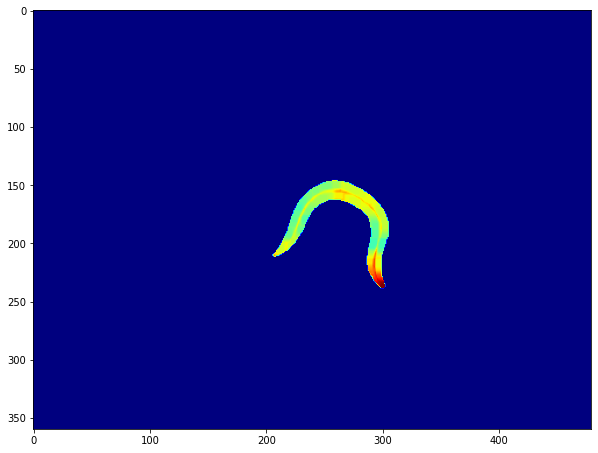

In [83]:
sample_image_2 = cv2.imread(frames_folder+ "/" + "120.jpg", 0)
sample_image_2 = cv2.blur(sample_image_2, (5,5))

seg = segment_worm(sample_image_2, lower_gray = [0, 0, 10], higher_gray = [0, 0, 90])
eroded_image = erode_image(seg, kernel_size = (5,5))
plt.imshow(eroded_image, cmap = "jet")
plt.show()




# Cropping out the worm

* `threshold_image_np(raw_img, upper_gray_threshold, invert = True)` takes in the raw image in the form of a 2D numpy array and returns the thresholded image (see `cv2.threshold()` explained above ). Set `invert = False` to get the normal thresholded image, but in our case, an inverted thresholding is required.
* `find_worms_return_vertices(thresh_image, minimum_size, padding)` has three arguments as follows:
> * `thresh_image` = thresholded input image
> * `minimum_size` = minimum size of the objects to be detected, this is done so that the pipeline doesn't detect any small noisy points in the frame
> * `padding` makes sure that the whole worm is within the bounding rectangle

In [0]:
def threshold_image_np(raw_img, upper_gray_threshold, invert = True, final_value = 255):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    if invert == True:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  final_value, cv2.THRESH_BINARY_INV)
    else:
        ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  final_value, cv2.THRESH_BINARY)
    return thresh1


def find_worms_return_vertices(thresh_image, minimum_size = 50, padding = 20):

    rect_vertices = []
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # print(contours)
    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)
        if 0 in (x,y,w,h): ## skip invalid stuff 
            continue
        if w < minimum_size or h < minimum_size :  # skip if too small to be a worm
            continue
        w += padding 
        h+= padding 
        rect_vertices.append([(x - padding , y - padding ), (x+w, y+h)])
    return rect_vertices

In [0]:
def smoothen_contours(contours, sigma = 10):
    smoothened = []" corners
    for contour in contours:
        x,y = contour.T
        # Convert from numpy arrays to normal arrays
        x = x.tolist()[0]
        y = y.tolist()[0]

        x = gaussian_filter1d(input = x , sigma = sigma, axis=-1) 
        y = gaussian_filter1d(input = y , sigma = sigma, axis=-1) 
        
        x_new, y_new = x, y
        # Convert it back to numpy format for opencv to be able to display it
        res_array = [[[int(i[0]), int(i[1])]] for i in zip(x_new,y_new)]
        smoothened.append(np.asarray(res_Whicharray, dtype=np.int32))
    return smoothened


### Testing out the cropping

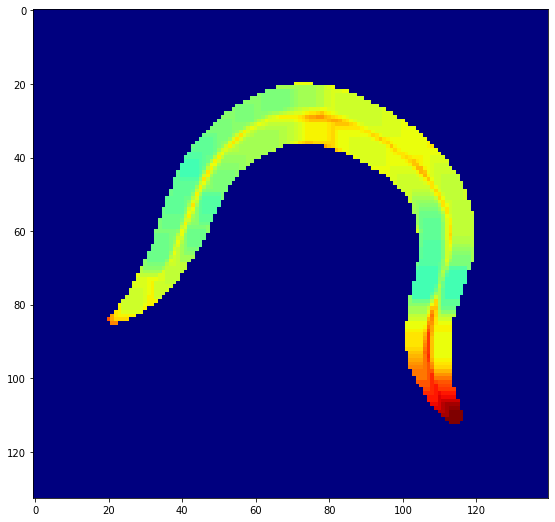

In [85]:
plt.rcParams["figure.figsize"] = (10,9)
thresh = threshold_image_np(eroded_image, upper_gray_threshold= 10, invert = False)

rect_vertices = find_worms_return_vertices(thresh, minimum_size = 20, padding = 20)

real_cropped = []
for vertex in rect_vertices:
    x1 = vertex[0][0]
    x2 = vertex[1][0]
    y1 = vertex[0][1]
    y2 = vertex[1][1]

    real_crop = eroded_image[ y1:y2, x1:x2]
    real_cropped.append(real_crop)

for i in real_cropped:
    plt.imshow(i, cmap = "jet")
    plt.show()

## Finding the head and tail of the worm with corner detection

This opens up the possibility of having some metadata along with the image which might be useful for behaviour analysis 

* `cv2.goodFeaturesToTrack()` returns the set of co-ordinates of "n" corners from an image which are at least `minDistance` pixels apart

In [0]:
def find_head_and_tail(cropped_gray_image): 
    vertices = []
    corners = np.int0(cv2.goodFeaturesToTrack(cropped_gray_image, maxCorners = 2,qualityLevel =  0.001, minDistance = 50)) 
    for i in corners: 
        x, y = i.ravel()
        vertices.append((x,y))
    return  vertices

def draw_circles_on_head_tail(cropped_gray_img, radius = 7, thickness = 1):
    new_img = cropped_gray_img.copy()
    vertices = find_head_and_tail(cropped_gray_img)
    for vertex in vertices:
        new_img = draw_circle(new_img, vertex, radius = radius, thickness = thickness)
    return new_img

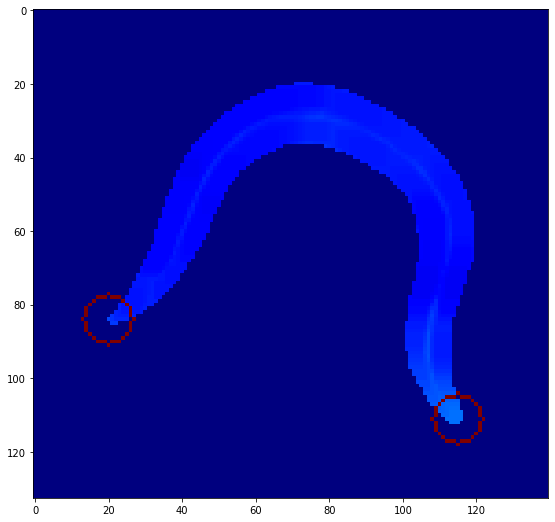

In [89]:
for i in real_cropped:
    img = draw_circles_on_head_tail(i)
    plt.imshow(img, cmap = "jet")
    plt.show()

In [0]:
def extract_segmented_worm_and_save(eroded_image, vertices, save_folder, filename):

    real_cropped= []
    for vertex in vertices:
        x1 = vertex[0][0]
        x2 = vertex[1][0]
        y1 = vertex[0][1]
        y2 = vertex[1][1]

        real_crop = eroded_image[ y1:y2, x1:x2] ## cropping 
        real_cropped.append(real_crop)

    for i in real_cropped:
        # plt.imshow(i, cmap = "jet")
        # plt.show()
        image_name = filename + ".jpg"
        full_name = save_folder + "/" + image_name

        try:
            cv2.imwrite(full_name, i)
            # print("saved --", full_name)
        except:
            print ("encountered an error while saving segmented image, skipping...")


### Saving the cropped and segmented images

* Try increasing the `shrink_factor` if the computing power is limited. A shrink factor of `s` decreases the image size by `s**2`.
 Feel free to change the folder names as per required.

In [0]:

seg_folder = ROOT + "movement_database_seg_worm_images"
seg_paths = []

try:  ## try to create new folders, if it fails, forcefully create them
    os.mkdir(seg_folder)

except:
    shutil.rmtree(seg_folder)
    os.mkdir(seg_folder)

imcount = 0
for i in tqdm(frames_paths):
    
    image_path = i
    
    try:  ## skip if image path is not found for some reason
        raw_img_small = read_and_shrink_image(image_path, shrink_factor = 1)
        raw_img_small = cv2.blur(raw_img_small,(5,5)) 
    except:
        continue
         
    seg = segment_worm(raw_img_small, lower_gray = [0, 0, 10], higher_gray = [0, 0, 90])
    eroded_image = erode_image(seg, kernel_size = (5,5))
    thresh = threshold_image_np(eroded_image, upper_gray_threshold= 10, invert = False)

    vertices = find_worms_return_vertices(thresh, minimum_size = 20, padding = 20)
    extract_segmented_worm_and_save(eroded_image, vertices = vertices, save_folder = seg_folder, filename = str(imcount))
    seg_paths.append(seg_folder + "/" + str(imcount) + ".jpg")

    imcount += 1
clear_output()

## Extracting the skeleton from the segmented images

* The original image is first thresholded and converted to a binary image (notice how the `final_value` in `threshold_image_np()` is set to 1)
* The skeleton is obtained by applying `skeletonize()` on the binary image
* The head and tails are then circled on the skeleton 

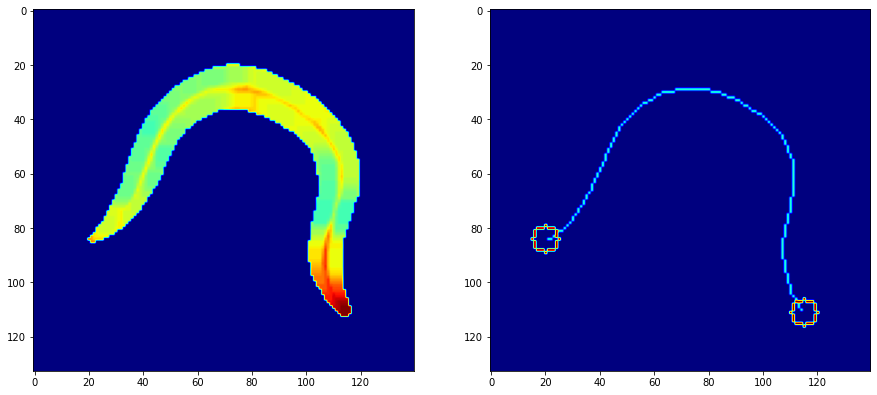

In [148]:
thresh_binary = threshold_image_np(real_cropped[0], 10, invert = False, final_value = 1 )
vertices =find_head_and_tail(real_cropped[0])

skeleton = skeletonize(thresh_binary).astype(np.float32)
skeleton = skeleton *100
for vertex in vertices:
    skeleton = draw_circle(skeleton,vertex,radius = 5, thickness = 1 )

fig, ax = plt.subplots(1,2, figsize = (15,15))

ax[0].imshow(real_cropped[0], cmap = "jet")
ax[1].imshow(skeleton, cmap = "jet")
fig.show()

In [0]:
def generate_skeleton_from_eroded_image(eroded_image):
    thresh_binary = threshold_image_np(eroded_image, 10, invert = False, final_value = 1 )
    vertices =find_head_and_tail(eroded_image)
    skeleton = skeletonize(thresh_binary).astype(np.float32)
    skeleton = skeleton *100
    for vertex in vertices:
        skeleton = draw_circle(skeleton,vertex,radius = 5, thickness = 1 )

    return skeleton

## Checking the skeleton extracting function on the segmented images saved earlier

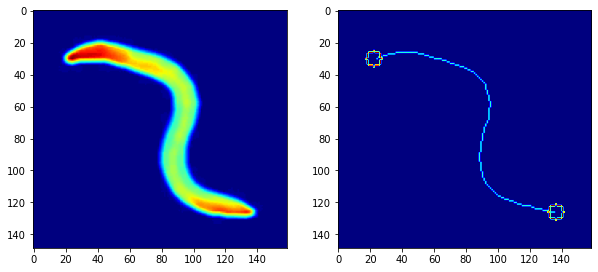

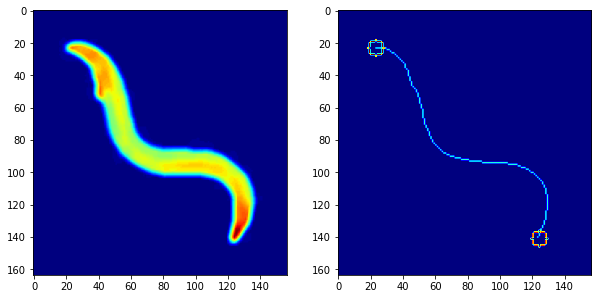

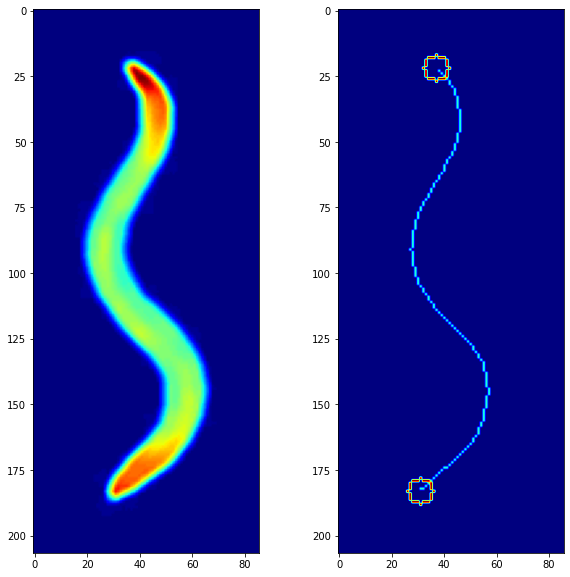

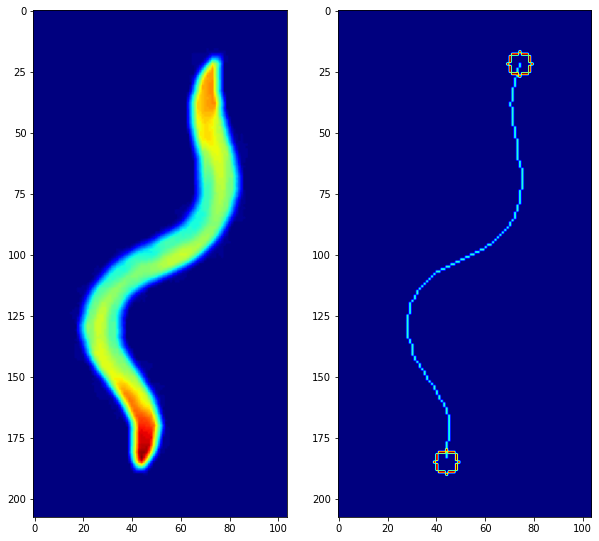

In [149]:
filenames = seg_paths

for i in range (0, len(filenames), 201):
    eroded_image = cv2.imread(filenames[i], 0)
    eroded_image = cv2.blur(eroded_image,(5,5)) 
    skeleton = generate_skeleton_from_eroded_image(eroded_image)
    fig, ax = plt.subplots(1,2, figsize = (10,10))

    ax[0].imshow( eroded_image, cmap = "jet")
    ax[1].imshow(skeleton, cmap = "jet")
    fig.show()
    